## Introduction

Statistics on predefined zones of the raster data are commonly used for analysis and to better understand the data. These zones are often provided within a single vector dataset, identified by certain vector attributes. For example, in the previous episodes, we defined infrastructure regions and built-up regions on Rhodes Island as polygons. Each region can be respectively identified as a "zone", resulting in two zones. One can evualuate the effect of the wild fire on the two zones by calculating the zonal statistics.

## Data loading

We have created `assets.gpkg` in Episode "Vector data in Python",  which contains the infrastructure regions and built-up regions . We also calculated the burned index in Episode "Raster Calculations in Python" and saved it in `burned.tif`. Lets load them:

In [1]:
output_folder = '../data/output_data/'

# Load burned index
import rioxarray
burned = rioxarray.open_rasterio(output_folder+'burned.tif')

# Load assests polygons
import geopandas as gpd
assets = gpd.read_file(output_folder+'assets.gpkg')

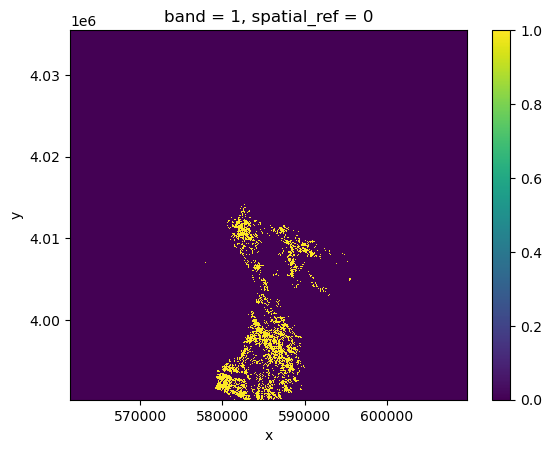

In [2]:
burned.plot()


## Align datasets

Before we continue, let's check if the two datasets are in the same CRS:

In [3]:
print(assets.crs)
print(burned.rio.crs)

EPSG:4326
EPSG:32635


The two datasets are in different CRS. Let's reproject the assets to the same CRS as the burned index raster:

In [4]:
assets = assets.to_crs(burned.rio.crs)

## Rasterize the vector data

One way to define the zones, is to create a grid space with the same extent and resolution as the burned index raster, and with the numerical values in the grid representing the type of infrastructure, i.e., the zones. This can be done by rasterize the vector data `assets` to the grid space of `burned`.

Let's first take two elements from `assets`, the geometry column, and the code of the region.

In [5]:
geom = assets[['geometry', 'code']].values.tolist()
geom

[[<POLYGON ((602761.27 4013139.375, 602764.522 4013072.287, 602771.476 4012998...>,
  1],
 [<POLYGON ((602779.808 4013298.838, 602772.497 4013266.01, 602768.577 4013242...>,
  1],
 [<POLYGON ((602594.855 4012962.661, 602593.423 4012983.028, 602588.485 401302...>,
  1],
 [<POLYGON ((603065.242 4013113.961, 603111.593 4013104.016, 603316.359 401306...>,
  1],
 [<POLYGON ((604667.306 4012868.545, 604666.966 4012867.076, 604652.425 401280...>,
  1],
 [<POLYGON ((604695.865 4013113.124, 604697.515 4013074.157, 604697.598 401307...>,
  1],
 [<POLYGON ((602733.338 4013063.75, 602724.281 4013065.604, 602716.417 4013066...>,
  1],
 [<POLYGON ((602715.649 4013128.546, 602715.964 4013132.105, 602717.674 401314...>,
  1],
 [<POLYGON ((602698.646 4013255.507, 602704.483 4013253.389, 602712.799 401324...>,
  1],
 [<POLYGON ((602628.876 4013090.757, 602621.48 4013093.659, 602613.414 4013097...>,
  1],
 [<POLYGON ((602761.308 4013148.291, 602760.414 4013139.116, 602758.626 401313...>,
  1],
 [<POLYGON

The raster image `burned` is a 3D image with a "band" dimension.

In [6]:
burned.shape

(1, 1131, 1207)

To create the grid space, we only need the two spatial dimensions. We can used `.squeeze()` to drop the band dimension:

In [7]:
burned_squeeze = burned.squeeze()
burned_squeeze.shape

(1131, 1207)

Now we can use `features.rasterize` from `rasterio` to rasterize the vector data `assets` to the grid space of `burned`:

In [8]:
from rasterio import features
assets_rasterized = features.rasterize(geom, out_shape=burned_squeeze.shape, transform=burned.rio.transform())
assets_rasterized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Perform zonal statistics

The rasterized zones `assets_rasterized` is a `numpy` array. The Python package `xrspatial`, which is the one we will use for zoning statistics, accepts `xarray.DataArray`. We need to first convert  `assets_rasterized`. We can use `burned_squeeze` as a template:

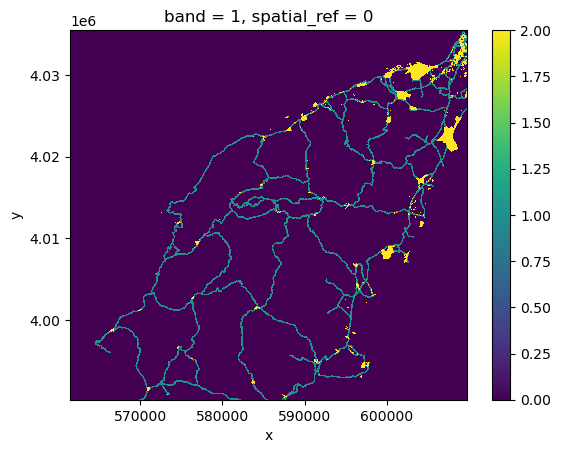

In [9]:
assets_rasterized_xarr = burned_squeeze.copy()
assets_rasterized_xarr.data = assets_rasterized
assets_rasterized_xarr.plot()

Then we can calculate the zonal statistics using the `zonal_stats` function:

In [10]:
from xrspatial import zonal_stats
stats = zonal_stats(assets_rasterized_xarr, burned_squeeze)
stats

,zone,mean,max,min,sum,std,var,count
0,0,0.022458,1.0,0.0,28980.0,0.148168,0.021954,1290406.0
1,1,0.008895,1.0,0.0,517.0,0.093895,0.008816,58120.0
2,2,0.000000,0.0,0.0,0.0,0.000000,0.000000,16591.0


The results provide statistics for three zones: `1` represents infrastructure regions, `2` represents built-up regions, and `0` represents the rest of the area.


:::keypoints
- Zones can be extracted by attribute columns of a vector dataset
- Zones can be rasterized using `rasterio.features.rasterize`
- Calculate zonal statistics with `xrspatial.zonal_stats` over the rasterized zones.
:::